In [1]:
from data_provider import ASSISTDataProvider

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

/afs/inf.ed.ac.uk/user/s17/s1758150/miniconda3/envs/mlp/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
DATA_DIR = '~/Data/'
BATCH_SIZE = 10

TrainingSet = ASSISTDataProvider(DATA_DIR, batch_size=BATCH_SIZE)

In [4]:
def embed(array, dimensions=100, rng=None):
    """Embed array as a vector from a Standard Normal in dimensions.
    
    Only the last dimension of the data is affected.
    
    Parameters
    ----------
    dimensions : int (default=100)
        DKT paper embeds one-hot inputs to 100 dims
    rng : numpy.random.RandomState (default=None)
    """
    if not rng:
        rng = np.random.RandomState()
    linear_map = rng.randn(data.shape[-1], dimensions)
    return np.dot(data, linear_map)

In [5]:
class LstmModel:
    
    def __init__(self, max_time_steps=973, feature_len=293):
        self.max_time_steps = max_time_steps
        self.feature_len = feature_len

    def build_graph(self, n_hidden_layers=1, n_hidden_units=200, keep_prob=1.0):
        """Build a TensorFlow computational graph for an LSTM network.

        Model based on "DKT paper" (see section 3): 
            Piech, Chris, et al. "Deep knowledge tracing." 
            Advances in Neural Information Processing Systems. 2015.
            
        Implementation based on "GD paper" (see section 3): 
            Xiong, Xiaolu, et al. "Going Deeper with Deep Knowledge Tracing."
            EDM. 2016.


        Parameters
        ----------
        n_hidden_layers : int (default=1)
            A single hidden layer was used in DKT paper
        n_hidden_units : int (default=200)
            200 hidden units were used in DKT paper
        keep_prob : float in [0, 1] (default=1.0)
            Probability a unit is kept in dropout layer
        """
        tf.reset_default_graph()

        # data. 'None' means any length batch size accepted
        self.inputs = tf.placeholder(
            tf.float32, 
            shape=[self.max_time_steps, None, self.feature_len], 
            name='inputs')
        
        self.targets = tf.placeholder(tf.float32, 
                                      shape=[None], 
                                      name='targets')
        
        # int type required for tf.gather function
        self.target_ids = tf.placeholder(tf.int32, 
                                         shape=[None], 
                                         name='target_ids')

        # model. LSTM layer(s) then linear layer (softmax applied in loss)
        cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden_units)
        if keep_prob < 1:
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, keep_prob)
        if n_hidden_layers > 1:
            cells = [cell for layer in n_hidden_layers]
            cell = tf.nn.rnn_cell.MultiRNNCell(cells)

        self.outputs, self.state = tf.nn.dynamic_rnn(cell=cell,
                                                     inputs=self.inputs,
                                                     dtype=tf.float32)
        
        sigmoid_w = tf.get_variable(dtype=tf.float32,
                                    name="sigmoid_w", 
                                    shape=[n_hidden_units, 
                                           self.feature_len])
        sigmoid_b = tf.get_variable(dtype=tf.float32,
                                    name="sigmoid_b", 
                                    shape=[self.feature_len])
        
        # reshaping as done in GD paper code 
        self.outputs = tf.concat(self.outputs, axis=1)
        self.outputs = tf.reshape(self.outputs, 
                                  shape=[-1, n_hidden_units])
        logits = tf.matmul(self.outputs, sigmoid_w) + sigmoid_b
        
        # reshaping as done in GD paper code 
        logits = tf.reshape(logits, [-1])
        logits = tf.gather(logits, self.target_ids)
        
        # loss
        self.loss = tf.reduce_mean(
            tf.losses.softmax_cross_entropy(
                logits=logits, onehot_labels=self.targets))
        learning_rate = 1e-10
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        self.objective = optimizer.minimize(self.loss)
        
        # predictions
        self.predictions = tf.sigmoid(logits)

In [6]:
Model = LstmModel()
Model.build_graph()

/afs/inf.ed.ac.uk/user/s17/s1758150/miniconda3/envs/mlp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Train

In [8]:
with tf.Session() as sess:
#     train_saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    
    losses = []
    i = 0
    for epoch in range(10): 
        
        for inputs, targets, target_ids in TrainingSet:
            inputs = np.squeeze(np.array(inputs, dtype=np.float32))
            targets = np.array(targets, dtype=np.float32)
            target_ids = np.array(target_ids, dtype=np.int32)
            
            # Train!
            _, loss = sess.run(
                [Model.objective, Model.loss],
                feed_dict={Model.inputs: inputs,
                           Model.targets: targets,
                           Model.target_ids: target_ids})
            
            losses.append(loss)
            
            i += 1
            #if i == 10:  # quit after 10 batches
            #    raise
            
            
#         save model
#         save_path = "{}/{}_{}.ckpt".format(
#             MODELS_DIR, experiment_name, epoch)
#         train_saver.save(sess, save_path)            
#     print("Saved model at", save_path)

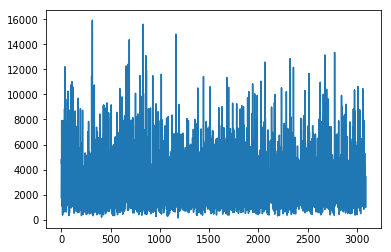

In [9]:
plt.plot(losses)